In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, RocCurveDisplay
from sklearn.svm import SVC

import shap

### Get the data

In [2]:
data = load_breast_cancer()

X, y = data.data, data.target

### Split the data into train and test. Create a pipeline.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(probability=True, random_state=0))])

param_grid = {
    'svc__kernel':['linear','poly','rbf'],
    'svc__C':[0.1,1,10]
}

In [4]:
gs = GridSearchCV(pipe, param_grid=param_grid, n_jobs=2, verbose=2)

In [5]:
gs.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.0s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.0s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.0s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.0s
[CV] END .....................svc__C=0.1, svc__kernel=linear; total time=   0.0s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.0s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.0s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.0s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.0s
[CV] END .......................svc__C=0.1, svc__kernel=poly; total time=   0.0s
[CV] END ........................svc__C=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ........................svc__C=0.1, svc__kernel=rbf; total time=   0.0s
[CV] END ...................

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=0))]),
             n_jobs=2,
             param_grid={'svc__C': [0.1, 1, 10],
                         'svc__kernel': ['linear', 'poly', 'rbf']},
             verbose=2)

### Parameters corresponding to best estimator and best score

In [6]:
print('Best score: ', gs.best_score_)
print(gs.best_params_)

Best score:  0.9780219780219781
{'svc__C': 0.1, 'svc__kernel': 'linear'}


In [7]:
y_pred = gs.predict(X_test)
y_prob = gs.predict_proba(X_test)[:,1]

### Accuracy and ROC_AUC score for best estimator

In [8]:
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('ROC_AUC score: ', roc_auc_score(y_test, y_prob))

Accuracy:  0.9736842105263158
ROC_AUC score:  0.9971419498253414


### We plot here the ROC curve.

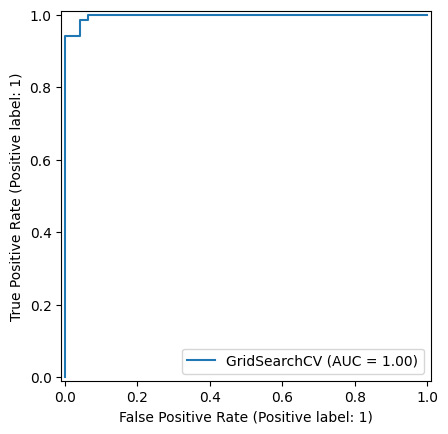

In [9]:
RocCurveDisplay.from_estimator(gs, X_test, y_test)

In [10]:
best_estim = gs.best_estimator_.named_steps.svc
print('No. of support vectors per class for best estimator:', best_estim.n_support_)


No. of support vectors per class for best estimator: [26 28]


### Effect of regularization. Here we fix kernel to be linear which we found above among the best parameters.

In [11]:
C = np.linspace(0.1, 20, 30)
acc = []
n_supp = []
iter = 1                

In [12]:
for c in C:
    svc = SVC(kernel='linear', random_state=0,C=c)
    svc.fit(X_train, y_train)
    y_pred = svc.predict(X_test)
    acc.append(accuracy_score(y_test, y_pred))
    n_supp.append(svc.n_support_.sum())

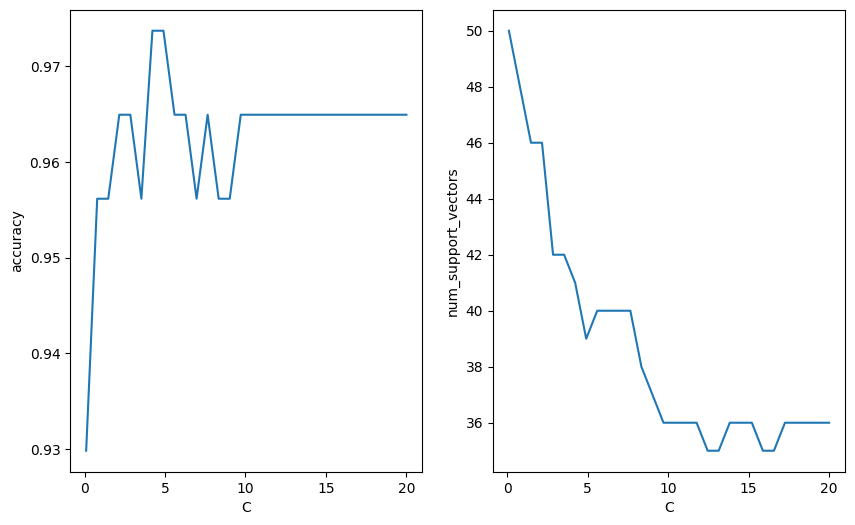

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

temp_arr = [acc, n_supp]
ylabels = ['accuracy', 'num_support_vectors']
i = 0

for axes in ax:
    axes.plot(C, temp_arr[i])
    axes.set_ylabel(ylabels[i])
    i+=1
    axes.set_xlabel('C')

As C increases, the number of support vectors decreases because the SVM enforces a narrower margin and penalizes misclassification more strictly. However, beyond around C=10, the model reaches a geometric limit where the decision boundary is fully defined by a minimal set of critical samples. These points lie on or inside the margin due to inherent data overlap. Therefore, the number of support vectors stabilizes and cannot be reduced further. Correspondingly, model accuracy also stabilizes because the decision boundary stops changing meaningfully beyond this point.

In [14]:
stab_index = 0
for i in range(len(acc)):
    if (acc[i] == acc[i+1]) & (acc[i+1]==acc[i+2]):
        stab_index = i
        break

print('Index where accuracy stops changing: ',stab_index)
print('Corresponding accuracy', acc[stab_index])
print('C value at this index. This will be the smallest C value at which accuracy stops changing.', C[stab_index])

Index where accuracy stops changing:  14
Corresponding accuracy 0.9649122807017544
C value at this index. This will be the smallest C value at which accuracy stops changing. 9.706896551724137


### Analysis using SHAP to check which features contribute most to prediction

  0%|          | 0/50 [00:00<?, ?it/s]

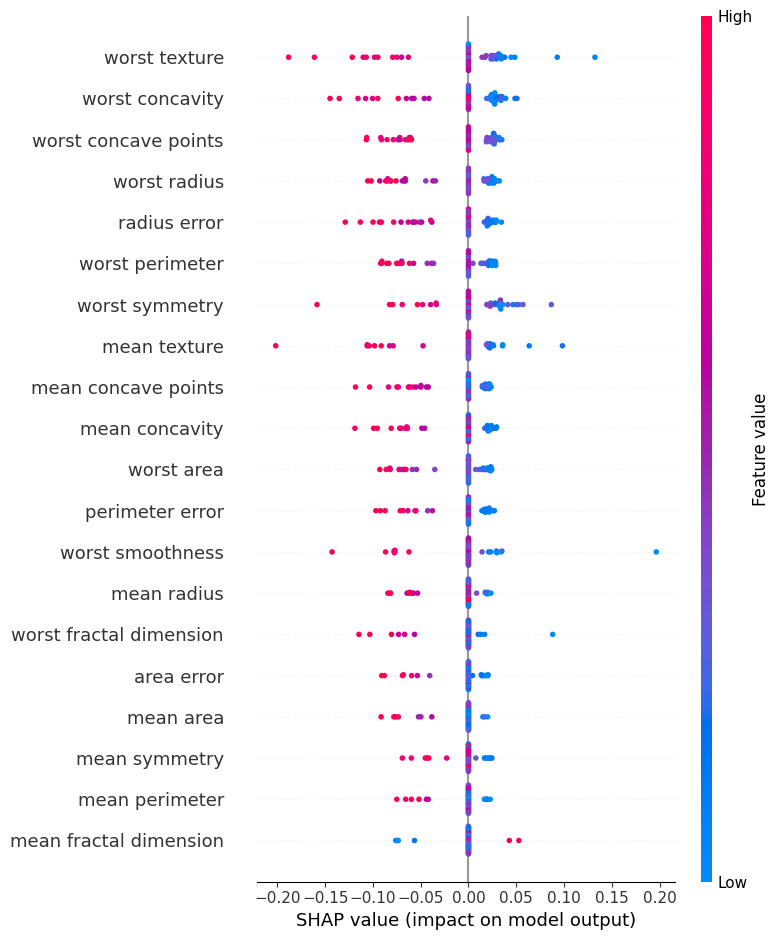

In [15]:
explainer = shap.KernelExplainer(gs.best_estimator_.predict, X_train[:50])
shap_values = explainer.shap_values(X_test[:50])
shap.summary_plot(shap_values, X_test[:50], feature_names=data.feature_names)

From above plot we see texture, concavity, radius and perimeter as important features contributing to predictions which is expected

High values(red dots) of texture, concavity, radius and perimeter correspond to negative values of SHAP and low values(blue dots) correspond to positive values of SHAP.

0 is for malignant and 1 is for benign. 

Positive SHAP value implies pushes towards class 1(benign) and negative SHAP values implies pushes towards class 0(malignant).

So the prediction from SHAP is as expected